## Data loading

First we need to load the MNIST dataset from disk. We will do 10-class classification for digit 0, 1, .., 9 from the MNIST dataset here.

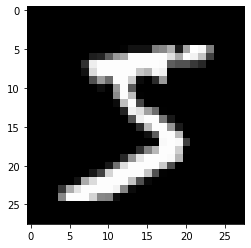

Train data shape:  (60000, 28, 28)
Train labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

plt.imshow(train_images[0], cmap='gray', interpolation = 'nearest')
plt.show()

# quickly check the shape of data
print('Train data shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_images.shape)
print('Test labels shape: ', test_labels.shape)


In [2]:
"""Preprocessing: we reshape the 28x28 grayscale MNIST images to 
784-dimensional vectors, which will be the network's inputs"""

train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

# now check the shape of data after reshaping
print('Train data shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_images.shape)
print('Test labels shape: ', test_labels.shape)

Train data shape:  (60000, 784)
Train labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


## Logistic Regression for 10-Class Image Classification

Use EDF to assemble a computational graph for logistic regression with the softmax function. You can reuse your code from excercise 1, but no need to use `SingleProbToProbVector` class anymore because we are now tackling image classification task on **10** different classes, instead of 2 classes. Moreover, please replace the output function that you used before from `Sigmoid` to `Softmax`.

Note that we don't need to implment the backward pass because the backward function of `Affine`, `Sigmoid` and `Softmax` have been implemented in EDF.

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension

edf.clear_compgraph()

# TO-DO: Define the computation graph here


In [ ]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""

def run_epoch(batch_size, data, labels, x_node, y_node, prob_node, loss_node=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples//batch_size
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        x_node.value = train_images[start:end]
        y_node.value = train_labels[start:end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))
        if loss_node:
            edf.Backward(loss_node)
            edf.UpdateParameters()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return 100*total_err/num_samples

def train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{} (learning rate: {})".format(epoch+1, num_epochs, edf.learning_rate))
        train_err = run_epoch(batch_size, train_images, train_labels, x_node, y_node, prob_node, loss_node)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(len(test_images), test_images, test_labels, x_node, y_node, prob_node)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

"""plot function"""
def plot(train_err_log, test_err_log):
    plt.xlabel("epochs")
    plt.ylabel("error (%)")
    plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
    plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
    plt.legend(['test error', 'train error'], loc='upper right')
    plt.show()
    plt.clf()

In [ ]:
"""now, we are ready to train the logistic regression. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

### Inline Question 1:
If your logistic regression model weight is randomly initalized, and no training is done as above. What test error do you think the model will get?


## MNIST Image Classification with MLP 

You may notice that the logistic regression model resulted with relatively high errors (~8%). Now it is time to see the power of neural network :)  

You now should develop a multi-layer perceptron with two layers.
Use EDF to assemble a computational graph for image classification using MLP with the vectorized images as input. Similar to the logistic regression task, the function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined. `prob_node` calculates the class probabilities for each training sample, while we use `CrossEntropyLoss` for the `loss_node` to calculate the loss for the entire training batch. `Softmax` should be also used for the output.

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

edf.clear_compgraph()

# TO-DO: Define the computation graph here


In [ ]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

# Architecture Choice

## Activation functions
We want to explore the performance when using different activation function.

First, you will implement a `Tanh` activation function by filling the missing
code in the `forward` and `backward` methods below. You can re-use parts of EDF's Sigmoid code.


In [ ]:
class Tanh(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # To-DO: implement the forward pass

    def backward(self):
        # To-DO: implement the backward pass

In [ ]:
"""the code below will plot the output and gradients computed by your
implementation of the Tanh component above. check if the plots match
Tanh(x) and dTanh/dx(x) as a sanity test of your implementation."""

values = np.linspace(-5,5,100)
edf.clear_compgraph()
params = edf.Parameter(values[None, :])
output = Tanh(params)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, params.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

Again, assemble a computational graph for image classification using MLP with `Tanh` activation function. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined.

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

np.random.seed(1234)
edf.clear_compgraph()

# TO-DO: Define the computation graph here


In [ ]:
"""now, we are ready to train the Tanh MLP network. """

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

Now, you will implement a ReLU activation function ReLU(x) = max(0,x).
implement the `forward` and `backward` methods of the following class.


In [ ]:
class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # To-DO: implement the forward pass

    def backward(self):
        # To-DO: implement the backward pass


In [ ]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
ReLU(x) and dReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2,2,100)
edf.clear_compgraph()
params = edf.Parameter(values[None, :])
output = ReLU(params)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, params.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

Again, assemble a computational graph for image classification using MLP with `ReLU` activation function. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined.

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

np.random.seed(1234)
edf.clear_compgraph()

# TO-DO: Define the computation graph here


In [ ]:
"""now, we are ready to train the ReLU MLP network. """

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

Now, you will implement a LeakyReLU(x) = max(cx, x) with the constant `c` = 0.01.
implement the `forward` and `backward` methods of the following class.


In [ ]:
class LeakyReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x
        self.c = 0.01

    def forward(self):
        # To-DO: implement the forward pass

    def backward(self):
        # To-DO: implement the backward pass
        

In [ ]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
LeakyReLU(x) and d LeakyReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2,2,100)
edf.clear_compgraph()
params = edf.Parameter(values[None, :])
output = LeakyReLU(params)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, params.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

Again, assemble a computational graph for image classification using MLP with `LeakyReLU` activation function. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined.

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

np.random.seed(1234)
edf.clear_compgraph()

# TO-DO: Define the computation graph here


In [ ]:
"""now, we are ready to train the ReLU MLP network. """
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

## Change Learning Rate
Let's check how changing the learning rate affects the model's train and test error. You should implement in a way to collect the network's final train/test errors for each of the learning rates in the array below. you should do this for MLPs with sigmoid and relu activations, and select the best learning rate for each of the two networks (w/ sigmoid and w/ relu activations)

Add code below to train MLPs with sigmoid activation. Your code should populate the arrays `train_err_per_lr` and `test_err_per_lr`, such that they contain the train and test errors of models trained with each learning rate in the learning_rates arrays, i.e. `train_err_per_lr[1]` should contain
the final train error of a sigmoid MLP trained with a learning
rate of 1.0.

Hint: you should be able to reuse most of the code above.

In [ ]:
num_epochs = 5
batch_size = 64
learning_rates = [0.1, 0.5, 1.0]

train_err_per_lr = []
test_err_per_lr = []

for i in range(len(learning_rates)):
    edf.learning_rate = learning_rates[i]
    np.random.seed(1234)
    edf.clear_compgraph()

    # TO-DO: add training code below
    # ...
    # ...
    # train_err_per_lr
    # test_err_per_lr

    
best_sigmoid_idx = np.argmin(test_err_per_lr)
best_sigmoid_lr = learning_rates[best_sigmoid_idx]


In [ ]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(best_sigmoid_lr, test_err_per_lr[best_sigmoid_idx], 'ok', label='_nolegend_')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Now repeat the experiments above but with a `ReLU` activation function in the hidden layer of a MLP. Fill below.

In [ ]:
num_epochs = 5
batch_size = 64
learning_rates = [0.1, 0.5, 1.0]

train_err_per_lr = []
test_err_per_lr = []

for i in range(len(learning_rates)):
    edf.learning_rate = learning_rates[i]
    np.random.seed(1234)
    edf.clear_compgraph()

    # TO-DO: add training code below
    # ...
    # ...
    # train_err_per_lr
    # test_err_per_lr


best_relu_idx = np.argmin(test_err_per_lr)
best_relu_lr = learning_rates[best_relu_idx]


In [ ]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(best_relu_lr, test_err_per_lr[best_relu_idx], 'ok', label='_nolegend_')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

## Change the number of MLP hidden layers
We will check how the number of hidden layers affects the model's performance. 

Similar to the exploration with different learning rates, you will see how the depth of the network `nLayers` affects its performance, first for a sigmoid network. 

Your code should supports multiple hidden layers (note the new nLayers argument). Each hidden layer should have nHiddens neurons.    
Hint: since now we might have more than one hidden layer, we can use a for loop over `nLayers` to add every layer (each intermediate `Affine` layer has `nHiddens` as both input and output)

Fill the missing code below to populate `train_err_per_depth` and `test_err_per_depth` accordingly

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

edf.learning_rate = best_sigmoid_lr
# edf.learning_rate = 0.5
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []

for nLayers in num_layers: # nLayers: number of hidden layers
    print ("Num Layers {}".format(nLayers))
    np.random.seed(1234)
    edf.clear_compgraph()
    
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = edf.Sigmoid(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    
    # train_err_per_depth
    # test_err_per_depth
    
    
best_sigmoid_idx = np.argmin(test_err_per_depth)
best_sigmoid_depth = num_layers[best_sigmoid_idx]


In [ ]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Now repeat the experiment above for a ReLU MLP

In [ ]:
edf.learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []


for nLayers in num_layers:
    print ("Num Layers {}".format(nLayers))
    np.random.seed(1234)
    
    edf.clear_compgraph()
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = ReLU(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    
    # train_err_per_depth
    # test_err_per_depth
    
best_relu_idx = np.argmin(test_err_per_depth)
best_relu_depth = num_layers[best_relu_idx]


In [ ]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

## Change the Width of MLP hidden layers
We will check how different hidden dimensions affect the model's performance. 
Fill the missing code below to populate `train_err_per_hidden` and `test_err_per_hidden` accordingly

You can reuse everything you coded above. 


In [ ]:
edf.learning_rate = best_sigmoid_lr
num_epochs = 5
batch_size = 64
num_hidden = [32, 64, 128]

nLayers = best_sigmoid_depth

train_err_per_hidden = []
test_err_per_hidden = []

for nHiddens in num_hidden:
    print ("Hidden Dimension {}".format(nHiddens))
    np.random.seed(1234)
    edf.clear_compgraph()
    
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = edf.Sigmoid(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    
    # train_err_per_hidden
    # test_err_per_hidden


In [ ]:
plt.xlabel("hidden dimension")
plt.ylabel("error (%)")
plt.plot(num_hidden, test_err_per_hidden, color='red')
plt.plot(num_hidden, train_err_per_hidden, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Again, Replace `Sigmoid` with `ReLU`

In [ ]:
edf.learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_hidden = [32, 64, 128]

nLayers = best_relu_depth

train_err_per_hidden = []
test_err_per_hidden = []

for nHiddens in num_hidden:
    print ("Hidden Dimension {}".format(nHiddens))
    np.random.seed(1234)
    edf.clear_compgraph()
    
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = ReLU(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    
    # train_err_per_hidden
    # test_err_per_hidden
    

In [ ]:
plt.xlabel("hidden dimension")
plt.ylabel("error (%)")
plt.plot(num_hidden, test_err_per_hidden, color='red')
plt.plot(num_hidden, train_err_per_hidden, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

### Inline Question 2:
Assume a model's train error keeps decreasing, but the test error increases when hidden dimension is too large (as shown below), what might be the reason?
